# Imports and setup

In [1]:
from transformers import ElectraForPreTraining, ElectraTokenizerFast, pipeline, AutoTokenizer, AutoModel
from datasets import load_dataset, ClassLabel
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
import nlp
import matplotlib.pyplot as plt

- Small-E-Czech is a transformer trained on Czech corpora by Seznam

In [2]:
model_name = "Seznam/small-e-czech"
# pipe = pipeline(task="text-classification", model=model_name)

# Data loading, manipulation and exploration

In [3]:
# df = pd.read_csv('data/sample_data.csv')
# df_train, df_test = train_test_split(df, test_size=0.33, random_state=42, shuffle=True)

# df_train.to_csv('data/sample_data_train.csv', index=False)
# df_test.to_csv('data/sample_data_test.csv', index=False)

# X_train = pd.read_pickle('data/X_known.pkl')
# y_train = pd.read_pickle('data/y_known.pkl')

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=17)

# df_train = pd.concat([X_train, y_train], axis=1)
# df_train.columns = ['text', 'label']
# df_test = pd.concat([X_test, y_test], axis=1)
# df_test.columns = ['text', 'label']

# df_train.to_csv('data/twitter_train.csv', index=False)
# df_test.to_csv('data/twitter_test.csv', index=False)

X_train = pd.read_csv('data/twitter_train.csv')
y_train = pd.read_csv('data/twitter_test.csv')

X_train.head()

,text,label
0,Za vlády @AndrejBabis se vše šíleně zdražilo. ...,before
1,@TheLilek @Don_Vito007 @michalsnobr @SpoluKoal...,after
2,@Telicka @AndrejBabis Nic.\nVšiml si ho tam ně...,after
3,@RomanKosek1 @AndrejBabiis @AndrejBabis Fake ú...,after
4,Tak jsem se konečně dostal k #ČauLidi a co nes...,after


In [4]:
# load into hugging_face dataset object and cast label as target

ds = load_dataset('csv', data_files={'train': 'data/twitter_train.csv', 'test': 'data/twitter_test.csv'})
label_features = ClassLabel(names=["before", "after"])

ds['train'] = ds['train'].cast_column("label", label_features)
ds['test'] = ds['test'].cast_column("label", label_features)

Using custom data configuration default-bbf2f84eeccc0b67
Found cached dataset csv (C:/Users/capek/.cache/huggingface/datasets/csv/default-bbf2f84eeccc0b67/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-4345259839aa99c0.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-c1fc664ea891a51e.arrow


In [5]:
# examine values

print(ds['train'].features)
print(ds['train'][0])
print(ds['test'].features)
print(ds['test'][0])

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['before', 'after'], id=None)}
{'text': 'Za vlády @AndrejBabis se vše šíleně zdražilo. Hlavně letos. Ve výsledku mají důchodci nižší kupní sílu než za pravicových vlád. Ale samozřejmě za to může inflace přivezená ze zahraničí. Ne nemůže. Můžete za to vy a vaše vláda!!!', 'label': 0}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['before', 'after'], id=None)}
{'text': 'A jedeeeeeem! Tohle si nechte zaramovat a povesit na zed v cele, @AndrejBabis ', 'label': 0}


In [6]:
# features = ds.features.copy()
# features["label"] = ClassLabel(names=["není zvíře", "je zvíře"])
# def adjust_labels(batch):
# #     batch["label"] = [sentiment + 1 for sentiment in batch["label"]]
#     return batch
# ds = ds.map(adjust_labels, batched=True, features=features)
# ds
# ds.features

In [7]:
# display dataset as pandas dataframe

ds['train'].set_format(type="pandas")
df = ds['train'][:]
df.head()

,text,label
0,Za vlády @AndrejBabis se vše šíleně zdražilo. ...,0
1,@TheLilek @Don_Vito007 @michalsnobr @SpoluKoal...,1
2,@Telicka @AndrejBabis Nic.\nVšiml si ho tam ně...,1
3,@RomanKosek1 @AndrejBabiis @AndrejBabis Fake ú...,1
4,Tak jsem se konečně dostal k #ČauLidi a co nes...,1


In [8]:
# map labels to label name

def label_int2str(row):
    return ds["train"].features["label"].int2str(row)

df['label_name'] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,Za vlády @AndrejBabis se vše šíleně zdražilo. ...,0,before
1,@TheLilek @Don_Vito007 @michalsnobr @SpoluKoal...,1,after
2,@Telicka @AndrejBabis Nic.\nVšiml si ho tam ně...,1,after
3,@RomanKosek1 @AndrejBabiis @AndrejBabis Fake ú...,1,after
4,Tak jsem se konečně dostal k #ČauLidi a co nes...,1,after


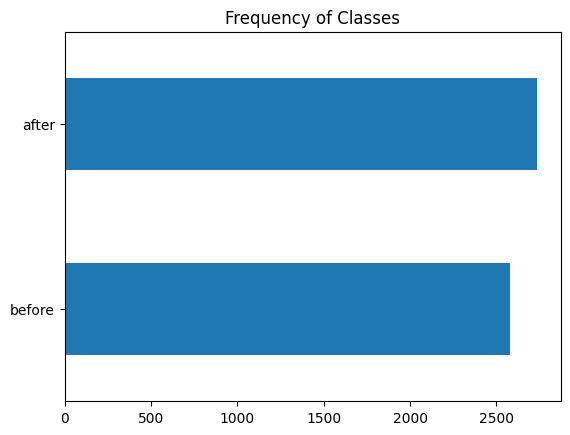

In [9]:
# displaying class frequencies

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

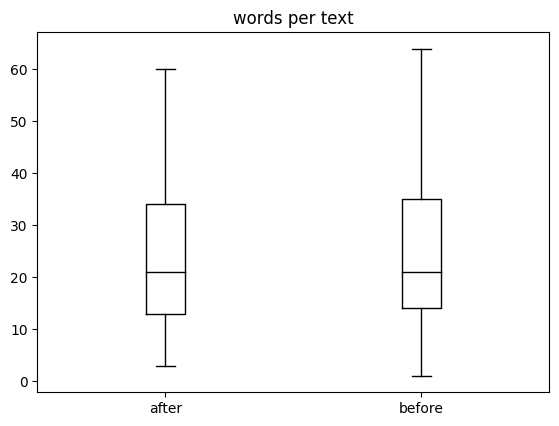

In [10]:
# displaying boxplots for word frequencies per class

df["words per text"] = df["text"].str.split().apply(len)
df.boxplot("words per text", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [11]:
ds.reset_format()

# Tokenization

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenized_data_train = tokenizer(ds['train']['text'], return_tensors="tf", padding=True, truncation=True)
labels_train = np.array(ds['train']['label'])
tokenized_data_test = tokenizer(ds['test']['text'], return_tensors="tf", padding=True, truncation=True)
labels_test = np.array(ds['test']['label'])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [13]:
# attention mask umožňuje ignorovat padding
tokenized_data_train

{'input_ids': <tf.Tensor: shape=(5314, 124), dtype=int32, numpy=
array([[    2,   272,  5052, ...,     0,     0,     0],
       [    2,    36,  2299, ...,     0,     0,     0],
       [    2,    36,  6152, ...,     0,     0,     0],
       ...,
       [    2, 21712,  3073, ...,     0,     0,     0],
       [    2,    36, 21780, ...,     0,     0,     0],
       [    2,    36, 29690, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(5314, 124), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(5314, 124), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [14]:
# navrácení tokenů k id
tokens = tokenizer.convert_ids_to_tokens(tokenized_data_train[0].ids)
tokens

['[CLS]',
 'za',
 'vlády',
 '@',
 'andrej',
 '##ba',
 '##bis',
 'se',
 'vše',
 'šílen',
 '##ě',
 'zdra',
 '##žilo',
 '.',
 'hlavně',
 'letos',
 '.',
 've',
 'výsledku',
 'mají',
 'důchodci',
 'nižší',
 'kupní',
 'sílu',
 'než',
 'za',
 'pravi',
 '##cových',
 'vlád',
 '.',
 'ale',
 'samozřejmě',
 'za',
 'to',
 'může',
 'inflace',
 'přivez',
 '##ená',
 'ze',
 'zahraničí',
 '.',
 'ne',
 'nemůže',
 '.',
 'můžete',
 'za',
 'to',
 'vy',
 'a',
 'vaše',
 'vláda',
 '!',
 '!',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '

In [15]:
# tisk jako string
tokenizer.convert_tokens_to_string(tokens)

'[CLS] za vlády @ andrejbabis se vše šíleně zdražilo. hlavně letos. ve výsledku mají důchodci nižší kupní sílu než za pravicových vlád. ale samozřejmě za to může inflace přivezená ze zahraničí. ne nemůže. můžete za to vy a vaše vláda!!! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [16]:
# počet tokenů ve slovníku
tokenizer.vocab_size

30522

In [17]:
# maximální délka vektoru
# (... mám o tom nějaké pochybnosti ....)

tokenizer.model_max_length

1000000000000000019884624838656

In [18]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

In [19]:
# tokenizace celého datasetu
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized = ds.map(tokenize, batched=True, batch_size=None)
tokenized

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8fd833be02e97cd7.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-8e6648eacea06ce7.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5314
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 591
    })
})

# Feature extraction

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at Seznam/small-e-czech were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
# tensorflow is also available
from transformers import TFAutoModel

tf_model = TFAutoModel.from_pretrained(model_name)

Some layers from the model checkpoint at Seznam/small-e-czech were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at Seznam/small-e-czech.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.


In [22]:
text = "Toto je zkušební text"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

print(outputs.last_hidden_state.size())

Input tensor shape: torch.Size([1, 6])
BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 3.6099e-01,  5.5451e-05, -1.2910e-04,  ...,  2.7867e-04,
           4.9307e-01, -1.3343e-04],
         [-1.9553e-01, -3.0069e-04, -1.0528e-04,  ...,  9.9560e-05,
          -1.1577e+00, -1.9735e-04],
         [-4.4455e-01, -4.6349e-04, -9.3824e-05,  ...,  3.3249e-04,
           1.7377e-01, -1.3628e-04],
         [-2.3091e-02, -2.4707e-04, -7.6978e-05,  ...,  6.1547e-04,
           6.3976e-01, -1.4361e-04],
         [ 1.0250e+00, -2.7454e-04, -7.3393e-05,  ...,  7.0218e-04,
           4.0734e-01, -2.5776e-04],
         [ 3.6190e-01,  5.5545e-05, -1.2914e-04,  ...,  2.7877e-04,
           4.9256e-01, -1.3352e-04]]]), past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)
torch.Size([1, 6, 256])


<i>"Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 256-dimensional vector is returned for each of the 6 input tokens. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:"</i>

In [23]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 256])

In [24]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [25]:
tokenized.set_format("torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
# token_type_ids?

In [26]:
# hidden states
hidden = tokenized.map(extract_hidden_states, batched=True)
hidden

Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-00d64d0035dcc232.arrow
Loading cached processed dataset at C:\Users\capek\.cache\huggingface\datasets\csv\default-bbf2f84eeccc0b67\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-ab426b9fc946eb7c.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 5314
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'hidden_state'],
        num_rows: 591
    })
})

In [27]:
X_train = np.array(hidden["train"]["hidden_state"])
X_test = np.array(hidden["test"]["hidden_state"])
y_train = np.array(hidden["train"]["label"])
y_test = np.array(hidden["test"]["label"])
X_train.shape, X_test.shape

((5314, 256), (591, 256))

# Feature visualization

In [28]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,11.670326,2.833446,0
1,13.298655,4.444511,1
2,5.032962,5.614967,1
3,7.645644,4.715765,1
4,11.591193,4.950837,1


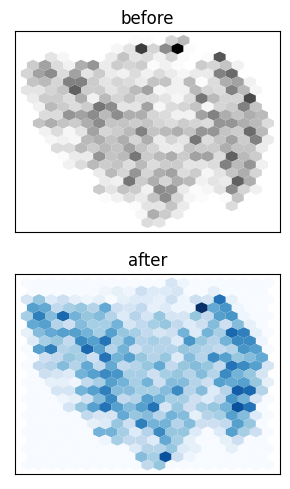

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(3,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues"]
labels = ds["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Modelling

In [30]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.5177664974619289

In [31]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.467005076142132

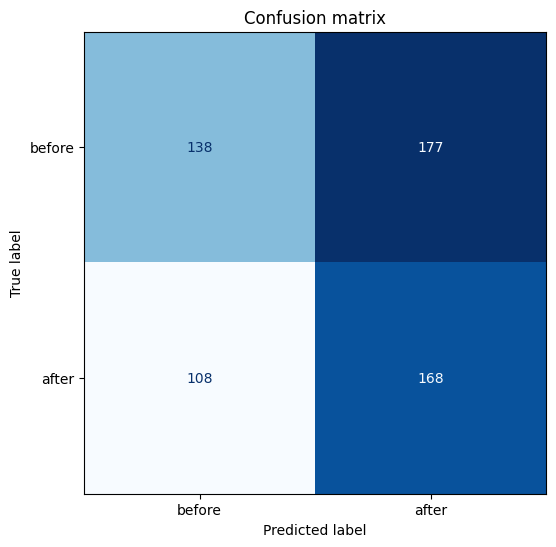

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, labels)

In [33]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at Seznam/small-e-czech were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at Seznam/small-e-czech and are newly initialized: ['classifier.dense.weight', 'classifier.

In [34]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [35]:
from transformers import Trainer, TrainingArguments

batch_size = 128
logging_steps = len(ds["train"]) // batch_size
my_model_name = f"{model_name}-finetuned-sample"
training_args = TrainingArguments(output_dir=my_model_name,
                                  num_train_epochs=15,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [36]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized["train"],
                  eval_dataset=tokenized["test"],
                  tokenizer=tokenizer)
trainer.train();

C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.692500,0.695130,0.467005,0.297332
2,0.691100,0.692372,0.502538,0.444074
3,0.687000,0.684929,0.560068,0.555603
4,0.677000,0.668760,0.626058,0.616112
5,0.650400,0.642288,0.649746,0.650071
6,0.607200,0.617894,0.663283,0.661161
7,0.566700,0.607287,0.685279,0.683738
8,0.545500,0.610302,0.678511,0.678057
9,0.517500,0.609744,0.695431,0.689192
10,0.498900,0.609907,0.692047,0.689628


In [37]:
preds_output = trainer.predict(tokenized["test"])
preds_output

PredictionOutput(predictions=array([[ 0.57710665, -0.6231781 ],
       [-0.06207819,  0.04237204],
       [ 0.8484938 , -0.8744642 ],
       ...,
       [ 0.7272419 , -0.7560736 ],
       [-0.27110365,  0.23037702],
       [ 0.66329175, -0.7033438 ]], dtype=float32), label_ids=array([0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0

In [38]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_preds

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,

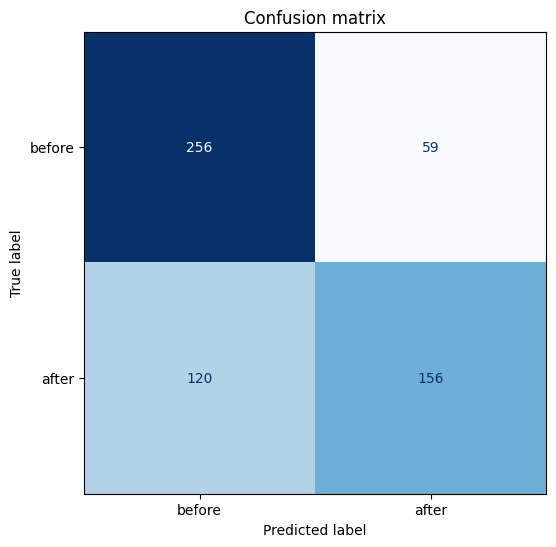

In [39]:
plot_confusion_matrix(y_preds, y_test, labels)

- keras finetuning

In [40]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels))

In [41]:
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = tokenized["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = tokenized["test"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

In [42]:
# does not work
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

Epoch 1/2


AttributeError: in user code:

    File "C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\transformers\modeling_tf_utils.py", line 1476, in train_step
        data = data_adapter.expand_1d(data)

    AttributeError: module 'keras.engine.data_adapter' has no attribute 'expand_1d'


# Error analysis

<i>"Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:"</i>

In [43]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}
     

In [44]:
# Convert our dataset back to PyTorch tensors
tokenized.set_format("torch", 
                            columns=["input_ids", "token_type_ids", "attention_mask", "label"])
# Compute loss values
tokenized["test"] = tokenized["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [47]:
tokenized.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tokenized["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [54]:
with pd.option_context("display.max_colwidth", None):
    display(df_test.sort_values("loss", ascending=False).head(10))

,text,label,predicted_label,loss
233,@TomasZdechovsky @AndrejBabis @SpoluKoalice @STANcz @PiratskaStrana s tou koalicí bych to zas tak jednoduše neviděl. Z cyklu „Už se perou“\n\n,after,before,1.909461
33,"@Sra93178461 @WendyBendy16 @cabanmart Sára je troll stbáckého fízla. Prostě odpad. Netřeba s ní (s ním, s tím?) komunikovat. \nBabiš prohrál, to je dobrý začátek.",after,before,1.886875
587,"@TomasZdechovsky @kducsl @AndrejBabis Zdechovský, ty jsi fakt fracek ze žluté tísně.",after,before,1.883517
131,"„Já se můžu – s prominutím – vysrat na milion sto tisíc hektolitrů piva a další věci. Ať to vylejou. V porovnání s tím, kolik se ztrácí každej tejden tím, že děcka nechoděj do školy, je to marginalita."" \n\nV hlavních rolích @profesorPrymula @RobertPlaga @AndrejBabis...",after,before,1.883513
230,@CNNPrima @AndrejBabis Ty totiž nechápeš vůbec nic.,after,before,1.881775
274,@Lenka_Hani @CNNPrima @AndrejBabis Jste mnohem větší.,after,before,1.878076
187,@CNNPrima @AndrejBabis Totální bordel a ostuda republiky! Se musí každý propadat za hlavu v zahraničí co se tu děje! Nejmenší státeček a největší bordel!,after,before,1.873709
547,"@ehucka1 @rkaldy @KohoutPavel @PetrHonzejk Mně je jedno co Babiš říkal nebo neříkal. Já ho nevolil. Stejně jako jsem nevolil ani jednu z koalic. Proto si myslím, že můžu celkem objektivně říct, že všechny tyhle strany na sebe házeli špínu, tedy si nic nedluží a proto pláč není na místě.",after,before,1.873117
521,"@Tina547736511 @tvtomas @CNNPrima @PrimaCnn Škoda, že jeho voličům nedojde ta skutečnost, že ono dlouhé čekání se vlastně vztahuje na to, jak tu osm let vládl právě Babiš. Zdravotnictví je v totálním rozkladu. Vůbec nezávidím tomu, kdo to po Vojtěchovi převezme, ať už to bude pan Válek nebo třeba pan Kaňkovský.",after,before,1.870393
59,@LukasGelnar @Vit_Rakusan @AndrejBabis @SpoluKoalice @PiratskaStrana @STANcz @PiratIvanBartos Všemocná digitalizace … co ajťák to jiny program . \nKrásně to bylo vidět u tvorby eshopu na dálniční známky . \n30 ajťáků a výsledek nepoužitelný ❗️ \nA teď ještě ministerstvo 😂 \nNěkdy raději používame tužku a čtverečkový papír 😂,after,before,1.869986


In [53]:
with pd.option_context("display.max_colwidth", None):
    display(df_test.sort_values("loss", ascending=True).head(10))

,text,label,predicted_label,loss
169,@TomasZdechovsky @P_Fiala @AndrejBabis @kducsl @SpoluKoalice A chodíte někdy nakupovat? Brambory stoji 14 Kč/kg a pivo je pod 10 Kč běžné.,before,before,0.160275
235,@TomasZdechovsky @P_Fiala @AndrejBabis @kducsl @SpoluKoalice Bude taky nějaký jarmark za fér ceny? :D :D,before,before,0.160540
98,"@MarcelaTesaov1 @PetrHonzejk @Vit_Rakusan @CNNPrima @P_Fiala @PiratskaStrana @AndrejBabis Stačí, díky za objasnění ;)",before,before,0.160568
361,"@TomasZdechovsky @P_Fiala @AndrejBabis @kducsl @SpoluKoalice Je vidět, že nevidíte nakupovat. Jinak byste takové nesmysly nemohl nikdy napsat.",before,before,0.160626
192,"@HavranekOndrej1 @jbchastand @AndrejBabis @DIEZEIT @lemondefr @mdrde Myslím ze by rad, aby ho v Evropě brali vážně …",before,before,0.160898
410,@F4FutureCZ @AndrejBabis @p_doubravsky Hele běžte se někam přilepit ať je klid 🤣🤣🤣🤣,before,before,0.160957
334,"@lunpav @PiratskaStrana @babis @AndrejBabis Můžete tomu zabránit! Přemluvte dost lidí, aby měl PirStan 51 procent! a nebude koalice s ODS!",before,before,0.161003
484,"@MichaelaUrban14 @TomasZdechovsky @P_Fiala @AndrejBabis @kducsl @SpoluKoalice Máslo (250g) stálo před rozvolněním cen k 7. 7. 1990 10 Kčs. Dnes jsem jej v Albertu koupil za 23,90 Kč.",before,before,0.161574
487,"@MaLaJMO @lukenukem78 @AndrejBabis @tomio_cz @jhamacek To bylo co?\n1) urážka\n2) tvrzení, že fotografie nezobrazuje utonulé dítě,\nnebo \n3) ještě něco jiného?",before,before,0.161687
250,@FackaDoTvarePK @V_Adamovsky @michalblaha Setkání Kaufnera s Pekarovou dokazuje že mladý Babiš je psychicky nemocný?\n\nJste normální?,before,before,0.161762


# Save model

In [55]:
path = f"models/{my_model_name}"
trainer.save_model(path)

In [56]:
classifier = pipeline("text-classification", model=path)

In [57]:
custom_tweet = "Dnes jsem si v parku hrál se psem."
preds = classifier(custom_tweet, return_all_scores=True)
preds

C:\Users\capek\pycharm_projects\Transformers_for_czech_language\venv\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'LABEL_0', 'score': 0.7973762154579163},
  {'label': 'LABEL_1', 'score': 0.20262382924556732}]]